# Call Log Prediction

## Background

ACME is a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, at ACME we are looking to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data Description

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

## Attributes

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)


## Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

## Success Metric(s)

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

## Bonus(es):

Q1. We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

Q2. What makes the customers buy? Tell us which feature we should be focusing more on.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
duration     40000 non-null int64
campaign     40000 non-null int64
y            40000 non-null object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


We do not have any null value in our dataset

In [4]:
df_copy = df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
le = LabelEncoder()
df_copy.job = le.fit_transform(df["job"])
df_copy.marital = le.fit_transform(df["marital"])
df_copy.education = le.fit_transform(df["education"])
df_copy.default = le.fit_transform(df["default"])
df_copy.housing = le.fit_transform(df["housing"])
df_copy.loan = le.fit_transform(df["loan"])
df_copy.contact = le.fit_transform(df["contact"])
df_copy.month = le.fit_transform(df["month"])
df_copy.y = le.fit_transform(df["y"])
df_copy.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0


I am removing **Job, Marital, Education, Contact, Day, and Month** columns because they are not contributing in regards of our model training.

In [6]:
X = df_copy.drop(['job','marital', 'education','contact','day','month'], axis=1)
X.head(5)

,age,default,balance,housing,loan,duration,campaign,y
0,58,0,2143,1,0,261,1,0
1,44,0,29,1,0,151,1,0
2,33,0,2,1,1,76,1,0
3,47,0,1506,1,0,92,1,0
4,33,0,1,0,0,198,1,0


In [7]:
X= X.drop(['y'], axis=1)
Y = df_copy.iloc[:,-1]

# CatBoost Classifier

In [8]:
%%time
catBoost_model = CatBoostClassifier(iterations = 200, 
                                learning_rate = 0.05, 
                                depth = 5,
                                verbose=False)
catBoost_result = cross_val_score(catBoost_model,X, Y,cv=5).mean()
print(str(catBoost_result*100) +' %')

92.7275 %
Wall time: 19.8 s


# Random Forest Classifier

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=40)
rf_result = cross_val_score(rf_model,X, Y,cv=5).mean()
print(str(rf_result*100) +' %')

92.1975 %
Wall time: 8.98 s


# XGBClassifier

In [10]:
%%time
from warnings import filterwarnings
filterwarnings('ignore')
xgb_model = XGBClassifier(learning_rate = 0.01, 
                    max_depth = 6,
                    min_samples_split = 2,
                    n_estimators = 100,
                    subsample = 0.8,
                    verbosity = 0)
xgb_result = cross_val_score(xgb_model,X, Y,cv=5).mean()
print(str(xgb_result*100) +' %')

92.90750000000001 %
Wall time: 13.7 s


# Decision Tree Classifier

In [11]:
%%time
cart_model = tree.DecisionTreeClassifier(max_depth = 2, min_samples_split = 2)
cart_result = cross_val_score(cart_model,X, Y,cv=5).mean()
print(str(cart_result*100) +' %')

93.3075 %
Wall time: 245 ms


# Gradient Boosting Classifier

In [12]:
%%time
gb_model = GradientBoostingClassifier(learning_rate = 0.01, 
                                 max_depth = 3,
                                 min_samples_split = 5,
                                 n_estimators = 100)
gb_result = cross_val_score(gb_model,X, Y,cv=5).mean()
print(str(gb_result*100) +' %')

92.75999999999999 %
Wall time: 20.4 s


# Logistic Regression

In [13]:
%%time
lr_model = LogisticRegression(solver= "liblinear")
lr_result = cross_val_score(lr_model,X, Y,cv=5).mean()
print(str(lr_result*100) +' %')

93.11749999999999 %
Wall time: 1.42 s


# Support Vector Machine (SVM)

In [14]:
%%time
svm_result = cross_val_score(SVC(gamma='auto'), X,Y,cv=5).mean()
print(str(svm_result*100) +' %')

92.75999999999999 %
Wall time: 45min 57s


# Average Performance Score 

In [15]:
results = {
    'CatBoost Classifier': catBoost_result,
    'Random Forest': rf_result,
    'XGBOOST': xgb_result,
    'Decision Tree': cart_result,
    'Gradient Boosting Classifier': gb_result,
    'Logistic Regression': lr_result,
    'SVM' : svm_result
    
}
d = pd.DataFrame(results.items(), columns= ["Models","Accuracy"])
d.sort_values(by="Accuracy", ascending=False)

,Models,Accuracy
3,Decision Tree,0.933075
5,Logistic Regression,0.931175
2,XGBOOST,0.929075
4,Gradient Boosting Classifier,0.927600
6,SVM,0.927600
0,CatBoost Classifier,0.927275
1,Random Forest,0.921975


The best model is Decision Tree Classifier and provide us **93.3%** accuracy.

## Correlation Matrix

In [16]:
corr = df_copy.drop(['age','job','marital', 'education','contact','day','month'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,default,balance,housing,loan,duration,campaign,y
default,1,-0.0700695,-0.0192294,0.0750061,-0.00859747,0.0121351,-0.00655945
balance,-0.0700695,1,-0.0499457,-0.0805959,0.014072,-0.00813665,0.0302318
housing,-0.0192294,-0.0499457,1,0.00426619,0.0224545,-0.0548227,-0.0543363
loan,0.0750061,-0.0805959,0.00426619,1,-0.00395158,0.000581787,-0.0310293
duration,-0.00859747,0.014072,0.0224545,-0.00395158,1,-0.0883873,0.461169
campaign,0.0121351,-0.00813665,-0.0548227,0.000581787,-0.0883873,1,-0.0403503
y,-0.00655945,0.0302318,-0.0543363,-0.0310293,0.461169,-0.0403503,1


# Data Analysis

We are extracting data of those customers who applied for term deposit

In [17]:
results = df[df.y == 'yes']

In [18]:
results

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
83,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
86,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
168,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39986,29,management,single,tertiary,no,637,yes,no,cellular,3,jun,340,1,yes
39988,55,management,divorced,tertiary,no,2383,no,no,cellular,3,jun,591,2,yes
39990,26,technician,single,secondary,no,1231,yes,no,cellular,3,jun,385,2,yes
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes


# AGE DISTRIBUTION

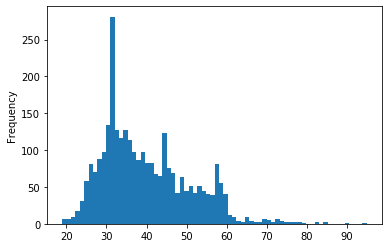

In [19]:
results["age"].plot.hist(bins=len(df["age"].unique()))

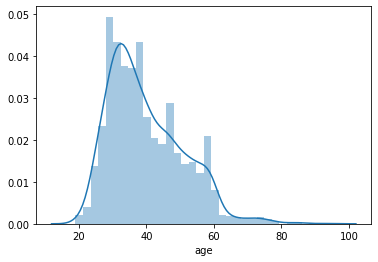

In [20]:
import seaborn as sns
sns.distplot(results["age"])

# JOB DISTRIBUTION

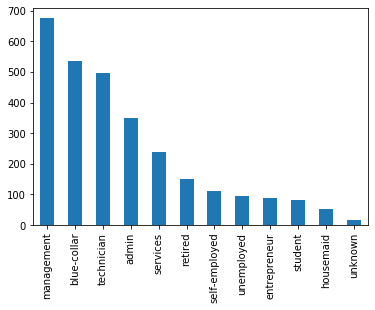

In [21]:
results["job"].value_counts().plot.bar()

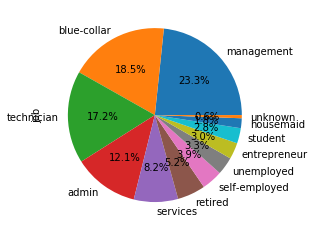

In [22]:
results["job"].value_counts().plot.pie(autopct='%1.1f%%')

# MARITAL DISTRIBUTION

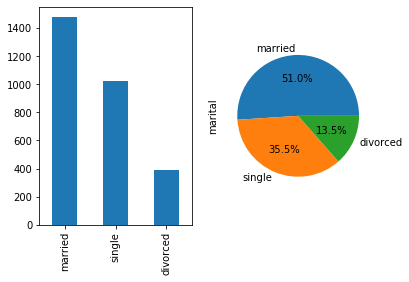

In [23]:
import matplotlib.pyplot as plt
fig, (ax, ax2) = plt.subplots(ncols=2)
results["marital"].value_counts().plot.bar(ax=ax)
results["marital"].value_counts().plot.pie(ax=ax2, autopct='%1.1f%%')

# EDUCATION DISTRIBUTION

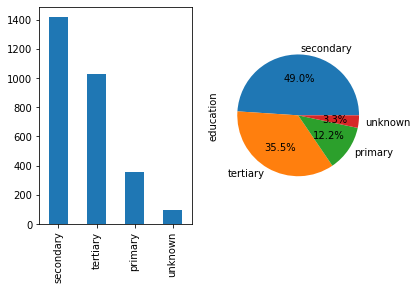

In [24]:
fig, (ax, ax2) = plt.subplots(ncols=2)
results["education"].value_counts().plot.bar(ax=ax)
results["education"].value_counts().plot.pie(ax=ax2, autopct='%1.1f%%')

# DEFAULT DISTRIBUTION

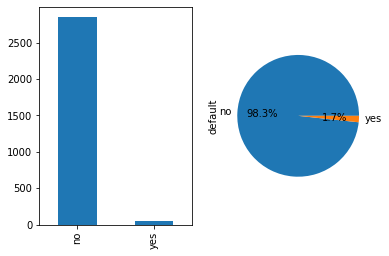

In [25]:
fig, (ax, ax2) = plt.subplots(ncols=2)
results["default"].value_counts().plot.bar(ax=ax)
results["default"].value_counts().plot.pie(ax=ax2, autopct='%1.1f%%')

# BALANCE DISTRIBUTION

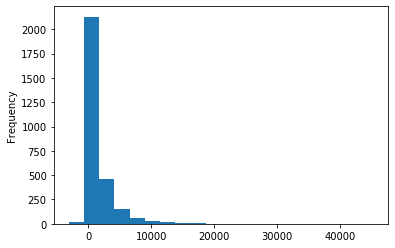

In [26]:
results["balance"].plot.hist(bins=20)

# HOUSE DISTRIBUTION

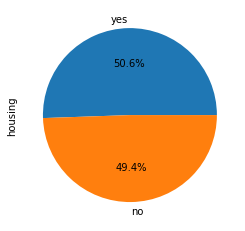

In [27]:
results["housing"].value_counts().plot.pie(autopct='%1.1f%%')

# LOAN DISTRIBUTION

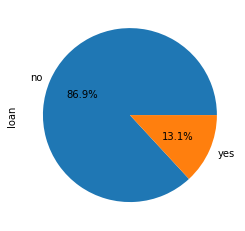

In [28]:
results["loan"].value_counts().plot.pie(autopct='%1.1f%%')

# CONTACT DISTRIBUTION

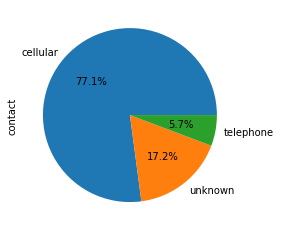

In [29]:
results["contact"].value_counts().plot.pie(autopct='%1.1f%%')

# DURATION DISTRIBUTION

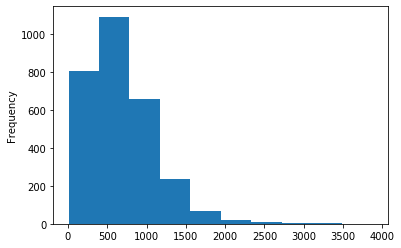

In [30]:
results["duration"].plot.hist(bins=10)

# CAMPAIGN DISTRIBUTION

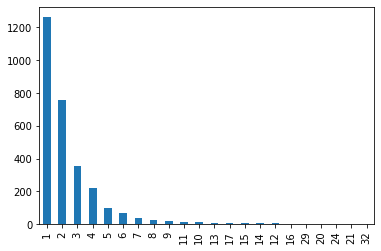

In [31]:
results["campaign"].value_counts().plot.bar()

# Q1. We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

Acording to our Data Analysis those people who are:

* Married 
* Working in a Management, Blue-collor, Technician, Admin profession 
* Do not have personal Loan 
* Do not default from bank,

are most likely to buy the **investment product** and they can be reachable via **cellular mediam**

# Q2. What makes the customers buy? Tell us which feature we should be focusing more on.

Although in the below Feature Importance graph **duration** has the highest importance rate. But duration alone is not a good metric to judge customer behavior. So, those customers who have excessive **balance** and usually do not have **personal loans** are more likely to buy **Investment Product**. The targeted people belongs to the age bracket of 20 to 50.

Feature ranking:
0. age (0.503899)
1. default (0.262999)
2. balance (0.156769)
3. housing (0.067261)
4. loan (0.004948)
5. duration (0.002850)
6. campaign (0.001274)


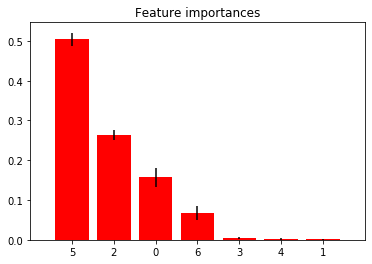

In [32]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f, X.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()